In [3]:
# Install packages
!pip install -q scikit-learn pandas matplotlib joblib seaborn nbformat
print('Packages installed')

Packages installed


In [4]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import joblib
sns.set()

In [5]:
# SECTION 2 — Load Dataset (Correct Column Names)
df = pd.read_csv("/content/personal_finance_tracker_dataset.csv")

In [6]:
# Fix column name if there's any space or case issue
df.columns = df.columns.str.strip()  # Remove any extra spaces
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values("date").reset_index(drop=True)

In [7]:
# Monthly aggregation (correct column names)
df_monthly = df.groupby(pd.Grouper(key='date', freq='M')).agg({
    'monthly_income': 'mean',
    'monthly_expense_total': 'mean',            # Yeh column hai!
    'actual_savings': 'mean',
    'credit_score': 'mean'
}).reset_index()

df_monthly = df_monthly.rename(columns={
    'monthly_income': 'income',
    'monthly_expense_total': 'expenses',
    'actual_savings': 'savings'
}).fillna(0)

print("Dataset Loaded & Cleaned Successfully!")
df_monthly.head()

Dataset Loaded & Cleaned Successfully!


/tmp/ipython-input-3901488490.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.groupby(pd.Grouper(key='date', freq='M')).agg({


,date,income,expenses,savings,credit_score
0,2019-01-31,3929.2259,2983.8925,1099.6620,680.70
1,2019-02-28,0.0000,0.0000,0.0000,0.00
2,2019-03-31,3967.0422,2934.4372,1154.6398,676.88
3,2019-04-30,4037.3772,3169.5038,1044.5680,679.82
4,2019-05-31,4051.4596,2916.6000,1253.9901,684.83


In [8]:
# SECTION 3 — Feature Engineering
df_monthly["extra_spendings"] = np.maximum(0, df_monthly["expenses"] - df_monthly["savings"])

df_monthly["savings_next_1"] = df_monthly["savings"].shift(-1)
df_monthly["savings_next_3"] = df_monthly["savings"].rolling(3).mean().shift(-1)
df_monthly["savings_next_6"] = df_monthly["savings"].rolling(6).mean().shift(-1)

df_monthly = df_monthly.dropna()

In [9]:
# SECTION 4 — Train Model
X = df_monthly[["income", "expenses", "extra_spendings", "credit_score"]]
Y = df_monthly[["savings_next_1", "savings_next_3", "savings_next_6"]]

In [10]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(Xs, Y, test_size=0.2, random_state=42)

In [12]:
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [13]:
joblib.dump(model, "finance_model.joblib")
joblib.dump(scaler, "scaler.joblib")
print("MODEL TRAINED 100% SUCCESSFULLY!")

MODEL TRAINED 100% SUCCESSFULLY!


In [14]:
# SECTION 5 — Prediction Function
def predict_finance(income, expenses, savings):
    extra = max(0, expenses - savings)
    X_new = np.array([[income, expenses, extra, 650]])
    X_scaled = scaler.transform(X_new)
    p = model.predict(X_scaled)[0]

    health = "Excellent" if p[0] > savings else "Poor" if p[0] < 0 else "Good"

    return {
        "next_month": f"{p[0]:.2f}",
        "next_3_months": f"{p[1]:.2f}",
        "next_6_months": f"{p[2]:.2f}",
        "health": health
    }

In [18]:
# SECTION 6 — User Input
print("\n" + "="*50)
print("              PERSONAL FINANCE AI ")
print("="*50)

monthly_income = float(input("Monthly Income (PKR): "))
monthly_expenses = float(input("Monthly Expenses (PKR): "))
current_savings = float(input("Current Monthly Savings (PKR): "))

results = predict_finance(monthly_income, monthly_expenses, current_savings)
total_balance = monthly_income - monthly_expenses + current_savings


              PERSONAL FINANCE AI 
Monthly Income (PKR): 80000
Monthly Expenses (PKR): 40000
Current Monthly Savings (PKR): 60000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [20]:
# SECTION 7 — AI Insights
print("\nAI INSIGHTS - User Financial Health")
print("-" * 50)

saving_ratio = (current_savings / monthly_income) * 100 if monthly_income > 0 else 0
expense_ratio = (monthly_expenses / monthly_income) * 100 if monthly_income > 0 else 0

print(f"Saving Rate: {saving_ratio:.1f}%   |   Expense Rate: {expense_ratio:.1f}%")

if expense_ratio > 100:
    print("Overspending! Aap income se zyada kharch kar rahe hain.")
    print("Tip: Quickly dining, shopping ya subscriptions band karo.")
elif expense_ratio > 80:
    print("High Spending! Aap 80% plus income kharch kar rahe hain.")
    print("Tip: 50-30-20 rule follow karo (50% needs, 30% wants, 20% savings)")
elif expense_ratio > 60:
    print("Balanced Spending! Aap control mein hain.")
    print("Tip: Ab saving ko 20% plus karne ki koshish karo.")
else:
    print("Excellent Control! Aap bohot smartly manage kar rahe hoo!")

if saving_ratio < 10:
    print("Low Savings! Mahine ka 10% bhi nahi bacha rahe.")
    print("Tip: Har mahine pehle saving karo, phir kharch.")
elif saving_ratio < 20:
    print("Good Start! Saving 10-20% hai.")
    print("Tip: Ise 20-30% tak le jao for financial freedom.")
else:
    print("Amazing Saving Habit! Aap future ke liye ready ho!")


AI INSIGHTS - User Financial Health
--------------------------------------------------
Saving Rate: 75.0%   |   Expense Rate: 50.0%
Excellent Control! Aap bohot smartly manage kar rahe hoo!
Amazing Saving Habit! Aap future ke liye ready ho!


In [23]:
# SECTION 8 — SAVING GOAL
print("\n" + "="*50)
print("               SAVING GOAL ")
print("="*50)

goal_name = input("What is your saving goal? (Car, House, Vacation, etc): ").title()
goal_amount = float(input("Estimated amount needed for this goal (PKR): "))

# Current monthly saving rate
current_monthly_saving = current_savings

# Calculate months needed at current rate
if current_monthly_saving > 0:
    months_current = goal_amount / current_monthly_saving
    print(f"\nAt Your Current Rate ({current_monthly_saving:,.0f} PKR/month):")
    print(f"   → {months_current:.0f} months (~{months_current/12:.1f} years) ")
else:
    print("\nWarning: Aap abhi saving nahi kar rahe → Goal kabhi achieve nahi hoga!")
    months_current = float('inf')

# Recommended rates
basic_rate = monthly_income * 0.20
strong_rate = monthly_income * 0.30

print("\n" + "—"*50)
print("   RECOMMENDED PLANS")
print("—"*50)

# Sirf tab dikhao jab current rate kam ho
if current_monthly_saving < basic_rate:
    months_basic = goal_amount / basic_rate
    print(f"Basic Plan (20% of income)")
    print(f"   Save: {basic_rate:,.0f} PKR/month → {months_basic:.0f} months (~{months_basic/12:.1f} years)")

if current_monthly_saving < strong_rate:
    months_strong = goal_amount / strong_rate
    print(f"Strong Plan (30% of income)")
    print(f"   Save: {strong_rate:,.0f} PKR/month → {months_strong:.0f} months (~{months_strong/12:.1f} years)")

# Agar user already tez chal raha hai → usko tareef do!
if current_monthly_saving >= strong_rate:
    print("Outstanding! Ap already 30% se bhi zyada bacha rahy hain!")
    print("   → Apna goal bohot jaldi achieve kar lain gy! Keep it up!")
elif current_monthly_saving >= basic_rate:
    print("Great Job! Ap already Basic Plan (20%) achieve kar chuka hai!")
    print("   → Strong Plan ki taraf jain, aur bhi jaldi goal poora ho jayega!")

print("="*50)


               SAVING GOAL 
What is your saving goal? (Car, House, Vacation, etc): car
Estimated amount needed for this goal (PKR): 5555000

At Your Current Rate (60,000 PKR/month):
   → 93 months (~7.7 years) 

——————————————————————————————————————————————————
   RECOMMENDED PLANS
——————————————————————————————————————————————————
Outstanding! Ap already 30% se bhi zyada bacha rahy hain!
   → Apna goal bohot jaldi achieve kar lain gy! Keep it up!


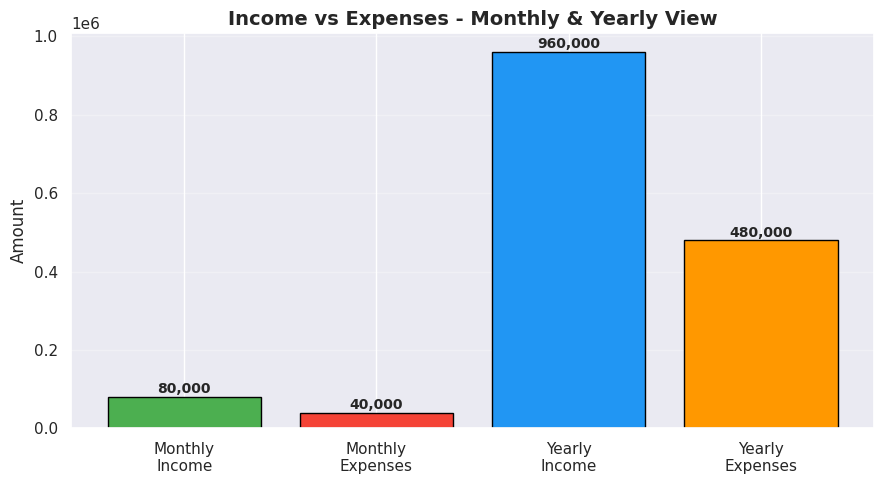

In [24]:
# SECTION 9 — Income vs Expense (Monthly + Yearly in One Graph)
plt.figure(figsize=(9,5))
categories = ['Monthly\nIncome', 'Monthly\nExpenses', 'Yearly\nIncome', 'Yearly\nExpenses']
amounts = [monthly_income, monthly_expenses, monthly_income*12, monthly_expenses*12]
colors = ['#4CAF50', '#F44336', '#2196F3', '#FF9800']

bars = plt.bar(categories, amounts, color=colors, edgecolor='black')
plt.title("Income vs Expenses - Monthly & Yearly View", fontsize=14, fontweight='bold')
plt.ylabel("Amount", fontsize=12)
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + max(amounts)*0.01,
             f'{height:,.0f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

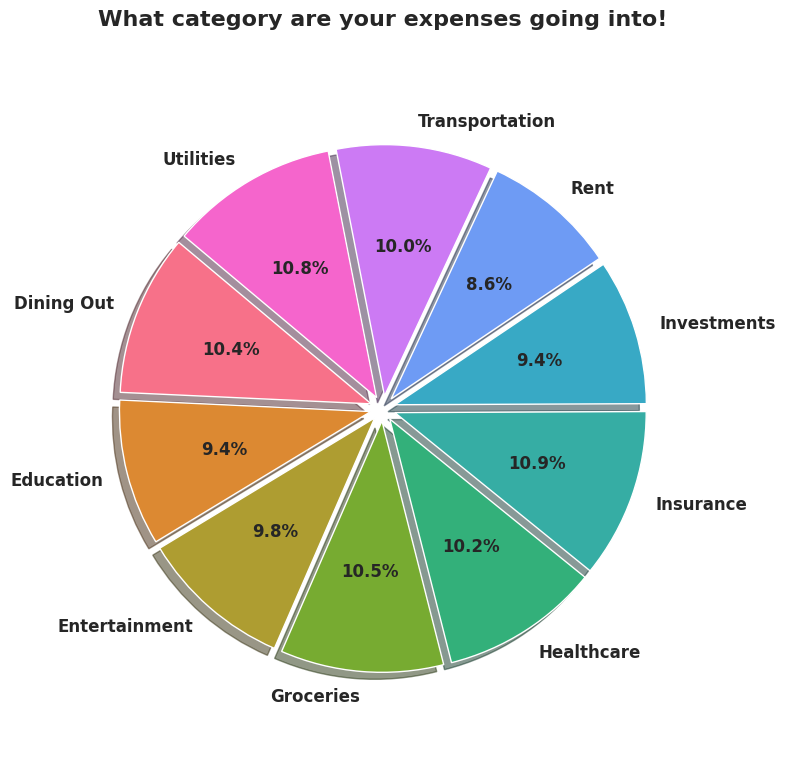

In [26]:
# SECTION 10 — Spending by Category
category_share = df.groupby('category')['monthly_expense_total'].sum()
user_category_spend = (category_share / category_share.sum()) * monthly_expenses

plt.figure(figsize=(8,8))
colors_pie = sns.color_palette("husl", len(user_category_spend))
explode = [0.05] * len(user_category_spend)  # Slight explode for 3D feel

wedges, texts, autotexts = plt.pie(user_category_spend, labels=user_category_spend.index, autopct='%1.1f%%',
                                   colors=colors_pie, startangle=140, explode=explode, shadow=True, textprops={'fontsize': 12, 'weight': 'bold'})

plt.title("What category are your expenses going into!", fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

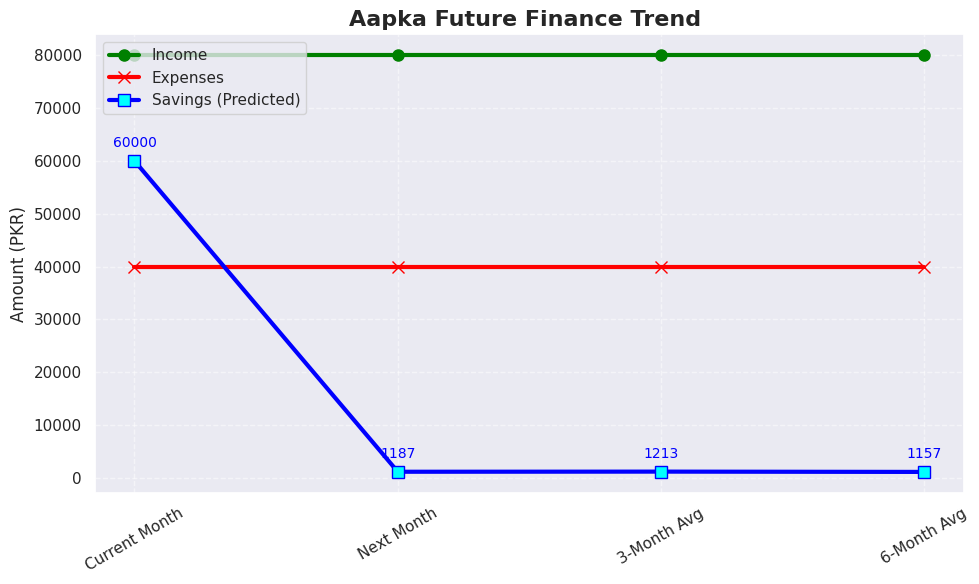

In [29]:
# SECTION 11 —  Personal Finance Trend
periods = ['Current Month', 'Next Month', '3-Month Avg', '6-Month Avg']
savings_trend = [current_savings, float(results['next_month']), float(results['next_3_months']), float(results['next_6_months'])]

plt.figure(figsize=(10,6))

plt.plot(periods, [monthly_income]*4, 'o-', label='Income', color='green', linewidth=3, markersize=8)
plt.plot(periods, [monthly_expenses]*4, 'x-', label='Expenses', color='red', linewidth=3, markersize=8)
plt.plot(periods, savings_trend, 's-', label='Savings (Predicted)', color='blue', linewidth=3, markersize=8, markerfacecolor='cyan')

# Add annotations for values
for i, val in enumerate(savings_trend):
    plt.annotate(f'{val:.0f}', (periods[i], val), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, color='blue')

plt.title("Aapka Future Finance Trend ", fontsize=16, fontweight='bold')
plt.ylabel("Amount (PKR)", fontsize=12)
plt.grid(True, alpha=0.5, linestyle='--')
plt.legend(loc='upper left')
plt.xticks(rotation=30, fontsize=11)
plt.tight_layout()
plt.show()

